In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(src_path)

from src import utils
from src.baselines_models import NodeClassModel, GF_NodeClassModel
from src.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows

SEED = 15
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:0


In [2]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [3]:
# Dataset must be from DGL
dataset_name = 'ChameleonDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: ChameleonDataset
Number of nodes: 2277
Number of features: 2325
Shape of signals: torch.Size([2277, 2325])
Number of classes: 5
Norm of A: 190.00262451171875
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.25
Edge homophily: 0.24


# Without normalizing the GSO

In [4]:
# BEST PARAMETERS  - 0.61
## Reaining params
N_RUNS = 20
N_EPOCHS = 6000  # 500
LR = .001  # .01
WD = .01  # .005
DROPOUT = .5

# BEST PARAMETERS
## Architecture params
N_LAYERS = 2
K = 2  # 2
HID_DIM = 64 # 8

## Model params
h0 = 1  # 1
NORM = False

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ReLU()
LAST_ACT = nn.Identity(dim=1)
LOSS_FN = nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [5]:
# Parameters
epochs = N_EPOCHS
lr = LR
wd = WD
drop = DROPOUT
L = N_LAYERS
K_aux = K
hid_dim = HID_DIM
norm = False
act = ACT
lact = LAST_ACT
loss = LOSS_FN
patience = 6000 #300

iters_aux = 1

err1 = np.zeros(iters_aux)
err2 = np.zeros(iters_aux)
for i in range(iters_aux):
    # Create model
    arch = GFGCN(IN_DIM, hid_dim, OUT_DIM, L, K_aux, act=act, l_act=lact,
                dropout=drop, diff_layer=GFGCN_noh_Layer)

    S = torch.Tensor(A).to(device)
    model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
    loss, acc = model.train(feat, labels, epochs, lr, wd, patience=patience)

    idx_max_acc = np.argmax(acc["val"])
    print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}  -  Best test acc: {np.max(acc["test"]):.3f}')
    acc_val = model.test(feat, model.S, labels, masks['val'])
    acc_test = model.test(feat, model.S, labels, masks['test'])
    print(f'Test acc (based on loss): {acc_test:.3f}')

    err1[i] = acc["test"][idx_max_acc]
    err2[i] = acc_test

Test acc at best val: 0.465  -  Best test acc: 0.531
Test acc (based on loss): 0.474


Acc at best val acc: 0.465 +- 0.000
Acc at test: 0.474 +- 0.000


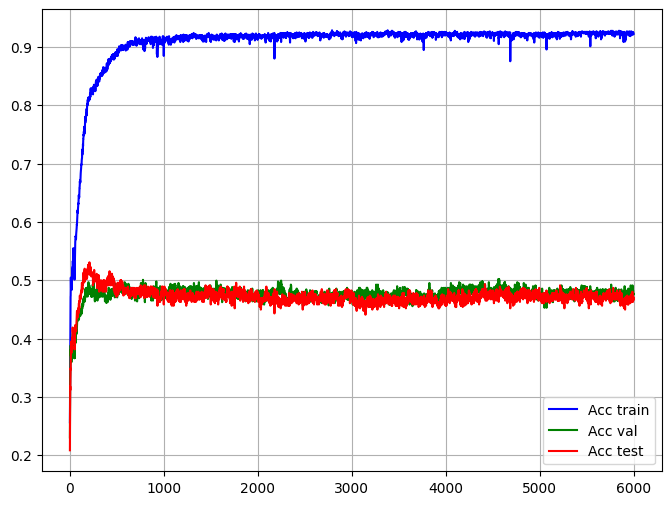

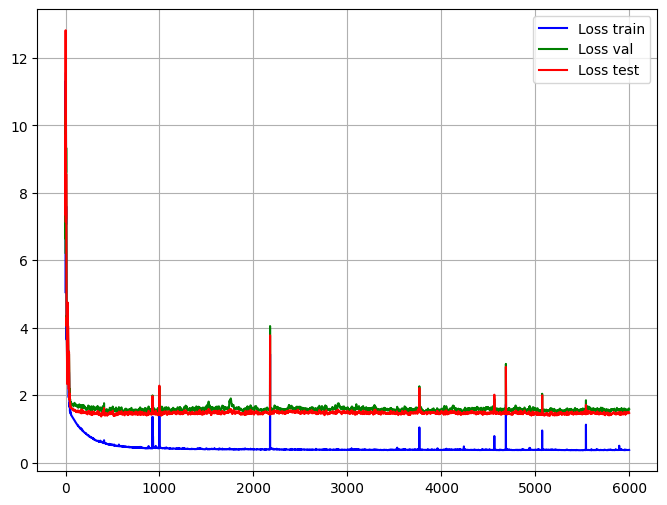

In [6]:
print(f'Acc at best val acc: {err1.mean():.3f} +- {err1.std():.3f}')
print(f'Acc at test: {err2.mean():.3f} +- {err1.std():.3f}')

# Plot
plt.figure(figsize=[8,6])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[8,6])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [8]:
EXPS = [
        {'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': .5},
        {'epochs': 300, 'lr': .0005, 'wd': 5e-4, 'drop': .5},
        
        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .5},
        {'epochs': 300, 'lr': .0005, 'wd': 1e-3, 'drop': .5},

        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 5e-3, 'drop': .5},

        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 1e-2, 'drop': .5},

        {'epochs': 200, 'lr': .01, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 1e-2, 'drop': .25},
        {'epochs': 200, 'lr': .01, 'wd': 1e-2, 'drop': .75},
        {'epochs': 200, 'lr': .001, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .001, 'wd': 1e-2, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 1e-2, 'drop': .75},

        {'epochs': 100, 'lr': .001, 'wd': 1e-2, 'drop': .5},
        {'epochs': 500, 'lr': .001, 'wd': 1e-2, 'drop': .5},
        {'epochs': 1000, 'lr': .001, 'wd': 1e-2, 'drop': .5},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, l_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0, diff_layer=GFGCN_noh_Layer)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'])

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)



-1: 200-0.01-0.0005-0.5: 0.434 (0.458)
-1: 200-0.005-0.0005-0.5: 0.445 (0.489)
-1: 200-0.001-0.0005-0.5: 0.480 (0.507)
-1: 300-0.0005-0.0005-0.5: 0.489 (0.511)
-1: 200-0.01-0.001-0.5: 0.417 (0.474)
-1: 200-0.005-0.001-0.5: 0.436 (0.489)
-1: 200-0.001-0.001-0.5: 0.504 (0.535)
-1: 300-0.0005-0.001-0.5: 0.428 (0.485)
-1: 200-0.01-0.005-0.5: 0.465 (0.504)
-1: 200-0.005-0.005-0.5: 0.482 (0.489)
-1: 200-0.001-0.005-0.5: 0.476 (0.504)
-1: 200-0.05-0.01-0.5: 0.452 (0.452)
-1: 200-0.01-0.01-0.5: 0.469 (0.500)
-1: 200-0.005-0.01-0.5: 0.482 (0.502)
-1: 200-0.001-0.01-0.5: 0.500 (0.502)
-1: 200-0.01-0.001-0: 0.399 (0.463)
-1: 200-0.01-0.001-0.25: 0.465 (0.491)
-1: 200-0.01-0.001-0.75: 0.452 (0.480)
-1: 200-0.001-0.005-0: 0.441 (0.491)
-1: 200-0.001-0.005-0.25: 0.439 (0.502)
-1: 200-0.001-0.005-0.75: 0.467 (0.500)
-1: 100-0.001-0.005-0.5: 0.480 (0.491)
-1: 500-0.001-0.005-0.5: 0.355 (0.509)
-1: 1000-0.001-0.005-0.5: 0.351 (0.485)
-2: 200-0.01-0.0005-0.5: 0.478 (0.500)
-2: 200-0.005-0.0005-0.5: 0.39

In [9]:
table1


,mean accs,med,std
200-0.01-0.0005-0.5,0.434649,0.439693,0.038189
200-0.005-0.0005-0.5,0.432785,0.434211,0.034648
200-0.001-0.0005-0.5,0.454167,0.458333,0.028279
300-0.0005-0.0005-0.5,0.458443,0.459430,0.026493
200-0.01-0.001-0.5,0.441009,0.448465,0.032371
200-0.005-0.001-0.5,0.442544,0.444079,0.024846
200-0.001-0.001-0.5,0.449232,0.470395,0.056079
300-0.0005-0.001-0.5,0.441118,0.457237,0.053973
200-0.01-0.005-0.5,0.461623,0.463816,0.016182
200-0.005-0.005-0.5,0.463925,0.467105,0.018769


In [10]:
table_over1

,mean accs,med,std
200-0.01-0.0005-0.5,0.473355,0.474781,0.023652
200-0.005-0.0005-0.5,0.482018,0.486842,0.019226
200-0.001-0.0005-0.5,0.485746,0.490132,0.023675
300-0.0005-0.0005-0.5,0.491009,0.502193,0.025677
200-0.01-0.001-0.5,0.483662,0.492325,0.025267
200-0.005-0.001-0.5,0.483662,0.485746,0.013545
200-0.001-0.001-0.5,0.494518,0.493421,0.024787
300-0.0005-0.001-0.5,0.484430,0.489035,0.023537
200-0.01-0.005-0.5,0.493531,0.491228,0.007830
200-0.005-0.005-0.5,0.486952,0.489035,0.010297


## Architecture design - Bias True

In [11]:
# layers, filter order, weightd
EXPS = [
        # {'L': 2, 'K': 2, 'hid_dim': 8},
        # {'L': 2, 'K': 3, 'hid_dim': 8},
        # {'L': 2, 'K': 4, 'hid_dim': 8},

        # {'L': 3, 'K': 2, 'hid_dim': 8},
        # {'L': 4, 'K': 2, 'hid_dim': 8},
        # {'L': 3, 'K': 3, 'hid_dim': 8},
        # {'L': 4, 'K': 3, 'hid_dim': 8},

        {'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        # {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        # {'L': 4, 'K': 3, 'hid_dim': 16},
    
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 4, 'hid_dim': 32},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        # {'L': 4, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 3, 'hid_dim': 32},
        # {'L': 4, 'K': 3, 'hid_dim': 32},

        {'L': 2, 'K': 2, 'hid_dim': 64},
        {'L': 2, 'K': 3, 'hid_dim': 64},
        # {'L': 2, 'K': 4, 'hid_dim': 64},

        {'L': 3, 'K': 2, 'hid_dim': 64},
        # {'L': 4, 'K': 2, 'hid_dim': 64},
        {'L': 3, 'K': 3, 'hid_dim': 64},
        # {'L': 4, 'K': 3, 'hid_dim': 64},

        {'L': 2, 'K': 2, 'hid_dim': 128},
        {'L': 2, 'K': 3, 'hid_dim': 128},

        {'L': 3, 'K': 2, 'hid_dim': 128},
        {'L': 3, 'K': 3, 'hid_dim': 128},

        {'L': 2, 'K': 2, 'hid_dim': 256},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, l_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0, diff_layer=GFGCN_noh_Layer)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

-1: 2-2-16: 0.248 (0.303)
-1: 2-3-16: 0.283 (0.320)
-1: 2-4-16: 0.272 (0.322)
-1: 3-2-16: 0.410 (0.423)
-1: 3-3-16: 0.202 (0.261)
-1: 2-2-32: 0.318 (0.487)
-1: 2-3-32: 0.279 (0.292)
-1: 2-4-32: 0.285 (0.298)
-1: 3-2-32: 0.292 (0.327)
-1: 3-3-32: 0.248 (0.287)
-1: 2-2-64: 0.469 (0.518)
-1: 2-3-64: 0.340 (0.349)
-1: 3-2-64: 0.274 (0.294)
-1: 3-3-64: 0.217 (0.254)
-1: 2-2-128: 0.489 (0.522)
-1: 2-3-128: 0.300 (0.322)
-1: 3-2-128: 0.294 (0.386)
-1: 3-3-128: 0.263 (0.268)
-1: 2-2-256: 0.471 (0.498)
-2: 2-2-16: 0.270 (0.371)
-2: 2-3-16: 0.204 (0.272)
-2: 2-4-16: 0.268 (0.285)
-2: 3-2-16: 0.265 (0.292)
-2: 3-3-16: 0.228 (0.298)
-2: 2-2-32: 0.498 (0.513)
-2: 2-3-32: 0.265 (0.333)
-2: 2-4-32: 0.217 (0.265)
-2: 3-2-32: 0.353 (0.371)
-2: 3-3-32: 0.200 (0.333)
-2: 2-2-64: 0.474 (0.502)
-2: 2-3-64: 0.287 (0.325)
-2: 3-2-64: 0.467 (0.480)
-2: 3-3-64: 0.246 (0.279)
-2: 2-2-128: 0.480 (0.502)
-2: 2-3-128: 0.252 (0.311)
-2: 3-2-128: 0.265 (0.344)
-2: 3-3-128: 0.228 (0.344)
-2: 2-2-256: 0.493 (0.509)
-3

In [12]:
table3

,mean accs,med,std
2-2-16,0.379276,0.407895,0.083970
2-3-16,0.256031,0.256579,0.029273
2-4-16,0.245724,0.255482,0.028182
3-2-16,0.297588,0.292763,0.047340
3-3-16,0.223684,0.225877,0.034957
2-2-32,0.436404,0.464912,0.057901
2-3-32,0.261952,0.263158,0.026320
2-4-32,0.241886,0.247807,0.037320
3-2-32,0.321382,0.290570,0.058703
3-3-32,0.225110,0.233553,0.025417


In [13]:
table_over3

,mean accs,med,std
2-2-16,0.434539,0.446272,0.049686
2-3-16,0.288925,0.289474,0.020394
2-4-16,0.289803,0.290570,0.021590
3-2-16,0.327851,0.313596,0.040362
3-3-16,0.279715,0.280702,0.027596
2-2-32,0.483114,0.486842,0.016703
2-3-32,0.296053,0.291667,0.018608
2-4-32,0.288596,0.287281,0.018327
3-2-32,0.358772,0.356360,0.046133
3-3-32,0.284211,0.278509,0.025094


## Architecture design - Bias False

In [14]:
# layers, filter order, weightd
EXPS = [
        {'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        # {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        # {'L': 4, 'K': 3, 'hid_dim': 16},
    
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 4, 'hid_dim': 32},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        # {'L': 4, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 3, 'hid_dim': 32},
        # {'L': 4, 'K': 3, 'hid_dim': 32},

        {'L': 2, 'K': 2, 'hid_dim': 64},
        {'L': 2, 'K': 3, 'hid_dim': 64},
        # {'L': 2, 'K': 4, 'hid_dim': 64},

        {'L': 3, 'K': 2, 'hid_dim': 64},
        # {'L': 4, 'K': 2, 'hid_dim': 64},
        {'L': 3, 'K': 3, 'hid_dim': 64},
        # {'L': 4, 'K': 3, 'hid_dim': 64},

        {'L': 2, 'K': 2, 'hid_dim': 128},
        {'L': 2, 'K': 3, 'hid_dim': 128},

        {'L': 3, 'K': 2, 'hid_dim': 128},
        {'L': 3, 'K': 3, 'hid_dim': 128},

        {'L': 2, 'K': 2, 'hid_dim': 256},
        ]

best_accs3b = np.zeros((len(EXPS), N_RUNS))
best_val_accs3b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, l_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0, diff_layer=GFGCN_noh_Layer, bias=False)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs3b[j,i] = np.max(acc["test"])
        best_val_accs3b[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3b = summary_table(best_accs3b, index_name)
table3b = summary_table(best_val_accs3b, index_name)

-1: 2-2-16: 0.248 (0.303)
-1: 2-3-16: 0.283 (0.320)
-1: 2-4-16: 0.272 (0.322)
-1: 3-2-16: 0.410 (0.423)
-1: 3-3-16: 0.202 (0.261)
-1: 2-2-32: 0.318 (0.487)
-1: 2-3-32: 0.279 (0.292)
-1: 2-4-32: 0.285 (0.298)
-2: 2-2-16: 0.270 (0.371)
-2: 2-3-16: 0.204 (0.272)
-2: 2-4-16: 0.268 (0.285)
-2: 3-2-16: 0.265 (0.292)
-2: 3-3-16: 0.228 (0.298)
-2: 2-2-32: 0.498 (0.513)
-2: 2-3-32: 0.265 (0.333)
-2: 2-4-32: 0.217 (0.265)
-3: 2-2-16: 0.404 (0.436)
-3: 2-3-16: 0.268 (0.311)
-3: 2-4-16: 0.206 (0.296)
-3: 3-2-16: 0.285 (0.311)
-3: 3-3-16: 0.241 (0.248)
-3: 2-2-32: 0.434 (0.458)
-3: 2-3-32: 0.268 (0.287)
-3: 2-4-32: 0.184 (0.268)
-4: 2-2-16: 0.432 (0.456)
-4: 2-3-16: 0.276 (0.289)
-4: 2-4-16: 0.298 (0.305)
-4: 3-2-16: 0.298 (0.298)
-4: 3-3-16: 0.164 (0.281)
-4: 2-2-32: 0.487 (0.502)
-4: 2-3-32: 0.294 (0.320)
-4: 2-4-32: 0.270 (0.292)
-5: 2-2-16: 0.461 (0.471)
-5: 2-3-16: 0.261 (0.272)
-5: 2-4-16: 0.193 (0.292)
-5: 3-2-16: 0.261 (0.316)
-5: 3-3-16: 0.191 (0.287)
-5: 2-2-32: 0.476 (0.487)
-5: 2-3-32: 

In [15]:
table3b

,mean accs,med,std
2-2-16,0.365461,0.404605,0.075214
2-3-16,0.230592,0.228070,0.027454
2-4-16,0.199123,0.195175,0.023969
3-2-16,0.285965,0.292763,0.048788
3-3-16,0.206360,0.211623,0.025356
2-2-32,0.428728,0.430921,0.030224
2-3-32,0.262390,0.256579,0.034600
2-4-32,0.202632,0.205044,0.022720


In [16]:
# table_over3b

## Nonlinearities and loss function

In [17]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], l_act=exp['lact'],
                     dropout=DROPOUT, init_h0=h0, diff_layer=GFGCN_noh_Layer)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.450 (0.487)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.471 (0.485)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.480 (0.504)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.485 (0.507)
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.498 (0.511)
-1: ReLU()-Identity()-NLLLoss(): 0.211 (0.248)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.458 (0.480)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.445 (0.485)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.456 (0.496)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.461 (0.491)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.452 (0.485)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.439 (0.476)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.450 (0.491)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.465 (0.482)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.461 (0.478)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.485 (0.504)
-2: ReLU()-LogSoftmax(dim=1)-N

In [18]:
table4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.450987,0.455044,0.020668
ReLU()-Softmax(dim=1)-NLLLoss(),0.443531,0.449561,0.022884
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.453947,0.468202,0.051812
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.463816,0.464912,0.021504
ReLU()-Identity()-CrossEntropyLoss(),0.468969,0.478070,0.022645
ReLU()-Identity()-NLLLoss(),0.205263,0.212719,0.024950
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.450548,0.452851,0.020283
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.443531,0.447368,0.022049
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.452632,0.451754,0.021736
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.451754,0.455044,0.019168


In [19]:
table_over4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.471820,0.476974,0.021878
ReLU()-Softmax(dim=1)-NLLLoss(),0.462610,0.463816,0.018756
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.489254,0.493421,0.019167
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.489364,0.489035,0.017061
ReLU()-Identity()-CrossEntropyLoss(),0.490241,0.495614,0.020648
ReLU()-Identity()-NLLLoss(),0.249232,0.253289,0.032314
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.473575,0.476974,0.019522
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.471272,0.475877,0.018477
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.476096,0.473684,0.016772
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.471820,0.475877,0.020006


# Normalizing the GSO

In [20]:
# BEST PARAMETERS  - 0.61
## Reaining params
N_RUNS = 10
N_EPOCHS = 200  # 500
LR = .005  # .01
WD = .01  # .005
DROPOUT = .5

# BEST PARAMETERS
## Architecture params
N_LAYERS = 2
K = 2  # 2
HID_DIM = 32 # 8

## Model params
h0 = 1  # 1
NORM = False

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.LeakyReLU()
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.CrossEntropyLoss()

NORM = True

## Training paramerters

In [21]:
EXPS = [
        {'epochs': 200, 'lr': .05, 'wd': 5e-4, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 5e-4, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': .5},
        
        {'epochs': 200, 'lr': .05, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .5},

        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 5e-3, 'drop': .5},

        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 1e-2, 'drop': .5},

        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        {'epochs': 100, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 1000, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        ]

best_accs5 = np.zeros((len(EXPS), N_RUNS))
best_val_accs5 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, l_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'])

        best_accs5[j,i] = np.max(acc["test"])
        best_val_accs5[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs5[j,i]:.3f} ({best_accs5[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over5 = summary_table(best_accs5, index_name)
table5 = summary_table(best_val_accs5, index_name)



/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: 200-0.05-0.0005-0.5: 0.182 (0.182)
-1: 200-0.01-0.0005-0.5: 0.182 (0.182)
-1: 200-0.005-0.0005-0.5: 0.182 (0.182)
-1: 200-0.001-0.0005-0.5: 0.182 (0.182)
-1: 200-0.05-0.001-0.5: 0.182 (0.182)
-1: 200-0.01-0.001-0.5: 0.182 (0.182)
-1: 200-0.005-0.001-0.5: 0.182 (0.182)
-1: 200-0.001-0.001-0.5: 0.182 (0.182)
-1: 200-0.05-0.005-0.5: 0.182 (0.182)
-1: 200-0.01-0.005-0.5: 0.182 (0.182)
-1: 200-0.005-0.005-0.5: 0.182 (0.182)
-1: 200-0.001-0.005-0.5: 0.182 (0.182)
-1: 200-0.05-0.01-0.5: 0.182 (0.182)
-1: 200-0.01-0.01-0.5: 0.182 (0.182)
-1: 200-0.005-0.01-0.5: 0.182 (0.182)
-1: 200-0.001-0.01-0.5: 0.182 (0.182)
-1: 200-0.005-0.001-0: 0.182 (0.182)
-1: 200-0.005-0.001-0.25: 0.182 (0.182)
-1: 200-0.001-0.001-0: 0.182 (0.182)
-1: 200-0.001-0.001-0.25: 0.182 (0.182)
-1: 100-0.005-0.001-0.5: 0.182 (0.182)
-1: 500-0.005-0.001-0.5: 0.182 (0.182)
-1: 1000-0.005-0.001-0.5: 0.182 (0.182)
-2: 200-0.05-0.0005-0.5: 0.189 (0.189)
-2: 200-0.01-0.0005-0.5: 0.189 (0.189)
-2: 200-0.005-0.0005-0.5: 0.189 (0

In [22]:
table5

,mean accs,med,std
200-0.05-0.0005-0.5,0.195833,0.191886,0.017325
200-0.01-0.0005-0.5,0.195833,0.191886,0.017325
200-0.005-0.0005-0.5,0.195833,0.191886,0.017325
200-0.001-0.0005-0.5,0.195833,0.191886,0.017325
200-0.05-0.001-0.5,0.195833,0.191886,0.017325
200-0.01-0.001-0.5,0.195833,0.191886,0.017325
200-0.005-0.001-0.5,0.195833,0.191886,0.017325
200-0.001-0.001-0.5,0.195833,0.191886,0.017325
200-0.05-0.005-0.5,0.195833,0.191886,0.017325
200-0.01-0.005-0.5,0.195833,0.191886,0.017325


## Architecture design

In [23]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 3, 'hid_dim': 8},
        {'L': 2, 'K': 4, 'hid_dim': 8},

        {'L': 3, 'K': 2, 'hid_dim': 8},
        {'L': 4, 'K': 2, 'hid_dim': 8},
        {'L': 3, 'K': 3, 'hid_dim': 8},
        {'L': 4, 'K': 3, 'hid_dim': 8},

        {'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        {'L': 4, 'K': 3, 'hid_dim': 16},
    
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 4, 'hid_dim': 32},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 4, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 3, 'hid_dim': 32},
        {'L': 4, 'K': 3, 'hid_dim': 32},

        {'L': 2, 'K': 2, 'hid_dim': 64},
        {'L': 2, 'K': 3, 'hid_dim': 64},
        {'L': 2, 'K': 4, 'hid_dim': 64},

        {'L': 3, 'K': 2, 'hid_dim': 64},
        {'L': 4, 'K': 2, 'hid_dim': 64},
        {'L': 3, 'K': 3, 'hid_dim': 64},
        {'L': 4, 'K': 3, 'hid_dim': 64},

        {'L': 2, 'K': 2, 'hid_dim': 100},
        {'L': 2, 'K': 3, 'hid_dim': 100},
        {'L': 2, 'K': 4, 'hid_dim': 100},

        {'L': 3, 'K': 2, 'hid_dim': 100},
        {'L': 4, 'K': 2, 'hid_dim': 100},
        {'L': 3, 'K': 3, 'hid_dim': 100},
        {'L': 4, 'K': 3, 'hid_dim': 100},
        ]

best_accs7 = np.zeros((len(EXPS), N_RUNS))
best_val_accs7 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, l_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs7[j,i] = np.max(acc["test"])
        best_val_accs7[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs7[j,i]:.3f} ({best_accs7[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over7 = summary_table(best_accs7, index_name)
table7 = summary_table(best_val_accs7, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: 2-2-8: 0.182 (0.182)
-1: 2-3-8: 0.182 (0.182)
-1: 2-4-8: 0.182 (0.182)
-1: 3-2-8: 0.182 (0.182)
-1: 4-2-8: 0.182 (0.182)
-1: 3-3-8: 0.182 (0.182)
-1: 4-3-8: 0.182 (0.182)
-1: 2-2-16: 0.182 (0.182)
-1: 2-3-16: 0.182 (0.182)
-1: 2-4-16: 0.182 (0.182)
-1: 3-2-16: 0.182 (0.182)
-1: 4-2-16: 0.182 (0.182)
-1: 3-3-16: 0.182 (0.182)
-1: 4-3-16: 0.182 (0.182)
-1: 2-2-32: 0.182 (0.182)
-1: 2-3-32: 0.182 (0.182)
-1: 2-4-32: 0.182 (0.182)
-1: 3-2-32: 0.182 (0.182)
-1: 4-2-32: 0.182 (0.182)
-1: 3-3-32: 0.182 (0.182)
-1: 4-3-32: 0.182 (0.182)
-1: 2-2-64: 0.182 (0.182)
-1: 2-3-64: 0.182 (0.182)
-1: 2-4-64: 0.182 (0.182)
-1: 3-2-64: 0.182 (0.182)
-1: 4-2-64: 0.182 (0.182)
-1: 3-3-64: 0.182 (0.182)
-1: 4-3-64: 0.182 (0.182)
-1: 2-2-100: 0.182 (0.182)
-1: 2-3-100: 0.182 (0.182)
-1: 2-4-100: 0.182 (0.182)
-1: 3-2-100: 0.182 (0.182)
-1: 4-2-100: 0.182 (0.182)
-1: 3-3-100: 0.182 (0.182)
-1: 4-3-100: 0.182 (0.182)
-2: 2-2-8: 0.189 (0.189)
-2: 2-3-8: 0.189 (0.189)
-2: 2-4-8: 0.189 (0.189)
-2: 3-2-8: 0.18

In [24]:
table7

,mean accs,med,std
2-2-8,0.195833,0.191886,0.017325
2-3-8,0.195833,0.191886,0.017325
2-4-8,0.195833,0.191886,0.017325
3-2-8,0.195833,0.191886,0.017325
4-2-8,0.195833,0.191886,0.017325
3-3-8,0.195833,0.191886,0.017325
4-3-8,0.195833,0.191886,0.017325
2-2-16,0.195833,0.191886,0.017325
2-3-16,0.195833,0.191886,0.017325
2-4-16,0.195833,0.191886,0.017325


## Nonlinearities and loss function

In [25]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs8 = np.zeros((len(EXPS), N_RUNS))
best_val_accs8 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], l_act=exp['lact'],
                     dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = NodeClassModel(arch, S, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs8[j,i] = np.max(acc["test"])
        best_val_accs8[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs8[j,i]:.3f} ({best_accs8[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over8 = summary_table(best_accs8, index_name)
table8 = summary_table(best_val_accs8, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.182 (0.182)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.182 (0.182)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.182 (0.182)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.182 (0.182)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.182 (0.182)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.182 (0.182)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.182 (0.182)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.182 (0.182)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.182 (0.182)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.182 (0.182)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.182 (0.182)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.189 (0.189)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.189 (0.189)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.189 (0.189)
-2: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.189 (0.189)
-2: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.189 (0.189)
-2: ELU(alp

In [26]:
table8

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.195833,0.191886,0.017325
ReLU()-Softmax(dim=1)-NLLLoss(),0.195833,0.191886,0.017325
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.195833,0.191886,0.017325
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.195833,0.191886,0.017325
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.195833,0.191886,0.017325
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.195833,0.191886,0.017325
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.195833,0.191886,0.017325
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.195833,0.191886,0.017325
Identity()-Softmax(dim=1)-CrossEntropyLoss(),0.195833,0.191886,0.017325
Identity()-Softmax(dim=1)-NLLLoss(),0.195833,0.191886,0.017325


# Comparing Models

In [27]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False}, # This should be the same as A-GCNN not norm
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

In [28]:
N_RUNS = 20

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, l_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, l_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=h0)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, l_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, l_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)

        loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = model.test(feat, model.S, labels, masks['test'])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')


# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
table_comp2 = summary_table(best_val_accs2, index_name)
        

- RUN: 1
	Kipf-none: acc = 0.325  -  acc (over) = 0.353
	Kipf-both: acc = 0.360  -  acc (over) = 0.410
	A-GCNN-False: acc = 0.454  -  acc (over) = 0.467


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:43: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(1/S.sum(1))
/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:51: RuntimeWarning: invalid value encountered in matmul
  return D_inv_sqr @ S @ D_inv_sqr


	A-GCNN-True: acc = 0.182  -  acc (over) = 0.182
	H-GCNN-False: acc = 0.441  -  acc (over) = 0.463
	H-GCNN-True: acc = 0.425  -  acc (over) = 0.454
	W-GCN-A-False: acc = 0.421  -  acc (over) = 0.450
	W-GCN-A-True: acc = 0.182  -  acc (over) = 0.182
- RUN: 2
	Kipf-none: acc = 0.384  -  acc (over) = 0.384
	Kipf-both: acc = 0.377  -  acc (over) = 0.384
	A-GCNN-False: acc = 0.465  -  acc (over) = 0.465
	A-GCNN-True: acc = 0.189  -  acc (over) = 0.189
	H-GCNN-False: acc = 0.436  -  acc (over) = 0.439
	H-GCNN-True: acc = 0.390  -  acc (over) = 0.390
	W-GCN-A-False: acc = 0.373  -  acc (over) = 0.482
	W-GCN-A-True: acc = 0.189  -  acc (over) = 0.189
- RUN: 3
	Kipf-none: acc = 0.366  -  acc (over) = 0.384
	Kipf-both: acc = 0.393  -  acc (over) = 0.395
	A-GCNN-False: acc = 0.404  -  acc (over) = 0.430
	A-GCNN-True: acc = 0.195  -  acc (over) = 0.195
	H-GCNN-False: acc = 0.428  -  acc (over) = 0.441
	H-GCNN-True: acc = 0.386  -  acc (over) = 0.445
	W-GCN-A-False: acc = 0.377  -  acc (over) = 0.4

In [29]:
table_comp

,mean accs,med,std
Kipf-none,0.359320,0.367325,0.027880
Kipf-both,0.353180,0.358553,0.023461
A-GCNN-False,0.432566,0.435307,0.021306
A-GCNN-True,0.195833,0.191886,0.017325
H-GCNN-False,0.430921,0.436404,0.021492
H-GCNN-True,0.405373,0.404605,0.021557
W-GCN-A-False,0.426864,0.429825,0.027463
W-GCN-A-True,0.195833,0.191886,0.017325


In [30]:
table_comp2

,mean accs,med,std
Kipf-none,0.359320,0.365132,0.028026
Kipf-both,0.360307,0.358553,0.022160
A-GCNN-False,0.423136,0.425439,0.021369
A-GCNN-True,0.195833,0.191886,0.017325
H-GCNN-False,0.426425,0.424342,0.020212
H-GCNN-True,0.410746,0.406798,0.028357
W-GCN-A-False,0.443531,0.447368,0.021101
W-GCN-A-True,0.195833,0.191886,0.017325


In [31]:
table_comp_over

,mean accs,med,std
Kipf-none,0.372149,0.376096,0.023964
Kipf-both,0.370395,0.372807,0.026866
A-GCNN-False,0.447917,0.455044,0.021497
A-GCNN-True,0.195833,0.191886,0.017325
H-GCNN-False,0.447478,0.447368,0.012434
H-GCNN-True,0.425439,0.425439,0.022642
W-GCN-A-False,0.456689,0.457237,0.020086
W-GCN-A-True,0.195833,0.191886,0.017325
